In [2]:
import sys
sys.path.append("../src")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, zero_one_loss
import itertools
import seaborn as sns
sns.color_palette('husl', n_colors=20)
from visual_functions import *
import torch
%matplotlib inline
fig_path="../paper/img/"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FuncFormatter)

def get_fscore(cm, names):
    av = 0
    p = []
    for i in range(len(names)):
        teller = 2 * cm[i,i]
        noemer = sum(cm[:,i]) + sum(cm[i,:])
        F = float(teller) / float(noemer)
        av += F
        #print('{0} {1:.2f}'.format(names[i],F*100))
        p.append(F*100)

    av = av/len(names)*100

    p = np.array(p)
    return p, av

def plot_multiple_fscore(names, cm_vi,cm_rp, labels=["baseline", "adaptive RP"]):
    width = 0.4
    #sns.set_color_codes("pastel")
    f1_vi,av_vi = get_fscore(cm_vi, names)
    f1_rp,av_rp = get_fscore(cm_rp, names)
    av = max(av_vi, av_rp)
    width=0.4
    plt.barh(np.arange(len(f1_vi)), f1_vi, width, align='center', alpha=0.8, label=labels[0])
    plt.barh(np.arange(len(f1_rp))+ width, f1_rp, width, align='center', alpha=0.5, label=labels[1])
    ax = plt.gca()
    ax.set(yticks=np.arange(len(names)) + width, yticklabels=names)
    ax.set_xlabel("$F_1$ macro (\%)'")

    ax.axvline(x=av,color='orange', linewidth=1.0, linestyle="--")
    a = '{0:0.2f}'.format(av)
    b = '$ $'+a
    if av > 75:
        OFFSET = -0.7
        plt.text(av-5,OFFSET,b,color='darkorange', fontsize=18)
    else:
        OFFSET = 0
        plt.text(av,OFFSET,b,color='darkorange')
    ax.set_ylabel("",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    leg=legend(ax,ncol=2, pos=(0.5, -0.2))
    return leg


def get_model_results(dataset="plaid"):
    model_name='CNN'
    width=50
    run_id=1
    cv=4
    multi_dimension=False
    isc=False
    names=lilac_names   if dataset=="lilac"   else plaid_names  
    dataset = dataset+"_isc" if isc else dataset
    baseline = False
    results_cm = {}
    results_f1={}
    results_mcc={}
    results_zl={}
    preds = {}
    trues = {}
    currents = {}
    results = pd.DataFrame( index=[ "vi", "adaptive" ], columns=["F1", "MCC", "ZL"])
    for image_type in ["vi", "adaptive" ]:
        if baseline:
            file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_baseline_{str(run_id)}_exp_two"

        else:
            file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}__exp_two" 
        if dataset=="lilac" and multi_dimension==True :
            file_name = file_name+"_multi-dimension-norm"

        pred = np.load("../results/"+file_name+"_pred.npy")
        true = np.load("../results/"+file_name+"_true.npy")
        #img = np.load("../results/"+file_name+"_images.npy")
        preds[image_type]=pred
        trues[image_type]=true

        mcc  = matthews_corrcoef(true, pred)
        zl   = zero_one_loss(true, pred)*100
        cm   = confusion_matrix(true, pred)
        f1   = get_Fmeasure(cm, names)
        results_cm[image_type]=cm
        results_f1[image_type]=f1
        results_mcc[image_type]=mcc
        results_zl[image_type]=zl
        f1  = np.load("../results/"+file_name+"_f1.npy")
        zl  = np.load("../results/"+file_name+"_z_one.npy")
        mcc  = np.load("../results/"+file_name+"_mcc.npy")
        print(f'results for {image_type} image type with {dataset} dataset')
        print(f"mcc:{round(mcc.mean(), 2)}:{round(mcc.std(), 2)}")
        print(f"f1:{round(f1.mean()*100, 2)}:{round(f1.std()*100, 2)}")
        print(f"zl:{round(zl.mean(), 2)}:{round(zl.std(), 2)}")
        print('')
        plt.figure(figsize=(9,9))
        plot_confusion_matrix(results_cm[image_type], names, title=None)
        savefig(fig_path+f"cm_{image_type}_{dataset}_agg", format=".pdf")

    fig=figure(fig_width=7, fig_height=7)
    plot_multiple_fscore(names, results_cm["vi"],results_cm['adaptive'], labels=["VI", "RP"])
    savefig(fig_path+f"fm_{dataset}_agg", format=".pdf")



    results["F1"] = pd.Series(results_f1)
    results["MCC"] = pd.Series(results_mcc)
    results["ZL"] = pd.Series(results_zl)
    results=results.round(2)
    print(f"results for {dataset}")
    print(results)
    print("")

    

## CNN Results

In [3]:
for dataset in ["plaid", "lilac"]:
    get_model_results(dataset=dataset)

results for vi image type with plaid dataset
mcc:0.89:0.01
f1:89.92:1.25
zl:10.08:1.29

results for adaptive image type with plaid dataset
mcc:0.97:0.01
f1:97.7:0.55
zl:2.3:0.55

results for plaid
             F1   MCC     ZL
vi        90.06  0.89  10.08
adaptive  97.75  0.97   2.30

results for vi image type with lilac dataset
mcc:0.84:0.01
f1:84.51:0.77
zl:14.95:0.87

results for adaptive image type with lilac dataset
mcc:0.97:0.01
f1:97.51:0.54
zl:2.49:0.54

results for lilac
             F1   MCC     ZL
vi        83.76  0.84  14.95
adaptive  97.40  0.97   2.49



## Parameters experiments

### Initilization parameters

In [4]:
def get_param_results(dataset="lilac"):
    model_name='CNN'
    width=50
    run_id=1
    cv=4
    multi_dimension=True
    isc=False
    names=lilac_names   if dataset=="lilac"   else plaid_names  
    dataset = dataset+"_isc" if isc else dataset
    image_type= "adaptive"
    baseline = False
    results_cm = {}
    results_f1={}
    results_mcc={}
    results_zl={}
    preds = {}
    trues = {}
    currents = {}
    for delta in [0, 1, 5, 10, 20, width]:
        F1=[]
        MCC=[]
        ZL = []
        for eps in [0, 1, 10, 20, 30, 40, 50]:
            file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_parameters_{str(delta)}_{str(eps)}"
            if dataset=="lilac" and multi_dimension==False :
                file_name = file_name+"_multi-dimension-norm"
            #print(f" load data for {file_name}")
            f1  = np.load("../results/"+file_name+"_f1.npy")
            zl  = np.load("../results/"+file_name+"_z_one.npy")
            mcc  = np.load("../results/"+file_name+"_mcc.npy")
            if delta==10 and eps >0:
                F1.append(f1[0]*100)
                MCC.append(mcc[0])
                ZL.append(zl[0])

        #plt.plot([1, 10, 20, 30, 40, 50], np.array(MCC) , label = f'$\delta=${delta}', marker='v',markersize=5)
        if delta==10:
            results_mcc[delta]=MCC
            results_f1[delta]=F1
            results_zl[delta]=ZL
    return results_f1


In [5]:
results_delta={}
for dataset in ["plaid", "lilac"]:
    results_mcc=get_param_results(dataset=dataset)
    results_delta[dataset]=np.hstack(list(results_mcc.values()))


In [6]:
fig=figure(fig_width=5)
plt.plot(np.array([1, 10, 20, 30, 40, 50]), results_delta["plaid"], marker='v',markersize=5, label="PLAID with $\delta=10$")
plt.plot(np.array([1, 10, 20, 30, 40, 50]), results_delta["lilac"], marker='v',markersize=5, label="LILAC with $\delta=10$")
plt.ylim(70, 100)
plt.xlabel('$\lambda$')
plt.ylabel('$F_1$ micro $(\%)$')
ax = plt.gca()
leg = ax.legend()
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
savefig(fig_path+f"paramaeter_delta_10", format=".pdf")

In [7]:
def get_param_eps_results(dataset="lilac"):
    model_name='CNN'
    width=50
    run_id=1
    cv=4
    multi_dimension=True
    isc=False
    names=lilac_names   if dataset=="lilac"   else plaid_names  
    dataset = dataset+"_isc" if isc else dataset
    image_type= "adaptive"
    baseline = False
    results_cm = {}
    results_f1={}
    results_mcc={}
    results_zl={}
    preds = {}
    trues = {}
    currents = {}
    for eps in [0, 1, 10, 20, 30, 40, 50]:
        F1=[]
        MCC=[]
        ZL = []
        for delta in [0, 1, 5, 10, 20, width]:
            file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_parameters_{str(delta)}_{str(eps)}"
            if dataset=="lilac" and multi_dimension==False :
                file_name = file_name+"_multi-dimension-norm"
            #print(f" load data for {file_name}")
            f1  = np.load("../results/"+file_name+"_f1.npy")
            zl  = np.load("../results/"+file_name+"_z_one.npy")
            mcc  = np.load("../results/"+file_name+"_mcc.npy")
            if eps==10 and delta >0:
                F1.append(f1[0]*100)
                MCC.append(mcc[0])
                ZL.append(zl[0])

        #plt.plot([1, 10, 20, 30, 40, 50], np.array(MCC) , label = f'$\delta=${delta}', marker='v',markersize=5)
        if eps==10:
            results_mcc[delta]=MCC
            results_f1[delta]=F1
            results_zl[delta]=ZL
    return results_f1


In [8]:
results_delta={}
for dataset in ["plaid", "lilac"]:
    results_mcc=get_param_eps_results(dataset=dataset)
    results_delta[dataset]=np.hstack(list(results_mcc.values()))

fig=figure(fig_width=5)
plt.plot(np.array([1,  5, 10, 20, 50]), results_delta["plaid"], marker='v',markersize=5, label="PLAID with $\lambda=10$")
plt.plot(np.array([1,  5, 10, 20, 50]), results_delta["lilac"], marker='v',markersize=5, label="LILAC with $\lambda=10$")
plt.ylim(70, 100)
plt.xlabel('$\delta$')
plt.ylabel('$F_1$ micro $(\%)$')
ax = plt.gca()
leg = ax.legend()
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
savefig(fig_path+f"paramaeter_lambda_10", format=".pdf")

### Input embending 


In [21]:
def get_param_width_results(dataset="lilac"):
    model_name='CNN'
    width=50
    run_id=1
    cv=4
    multi_dimension=True
    isc=False
    names=lilac_names   if dataset=="lilac"   else plaid_names  
    dataset = dataset+"_isc" if isc else dataset
    image_type= "adaptive"
    baseline = False
    
    results_f1={}
    results_mcc={}
    results_zl={}
    results_time={}
    preds = {}
    trues = {}
    currents = {}
    delta=10
    eps=10
    widths = [30, 50, 60, 80, 100]
    results = pd.DataFrame( index=widths, columns=["F1", "MCC", "ZL", "TIME"])
    for width in widths:
        file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_parameters_emb_size_{str(delta)}_{str(eps)}"
        if dataset=="lilac" and multi_dimension==False :
            file_name = file_name+"_multi-dimension-norm"
           
        f1  = np.load("../results/"+file_name+"_f1.npy").flatten()
        zl  = np.load("../results/"+file_name+"_z_one.npy").flatten()
        mcc  = np.load("../results/"+file_name+"_mcc.npy").flatten()
        time = np.load("../results/"+file_name+"_time.npy").flatten()
        
        results_f1[width]=list(f1)[0]
        results_mcc[width]=list(mcc)[0]
        results_zl[width]=list(zl)[0]
        results_time[width]=list(time)[0]/60
        
    results["F1"] = pd.Series(results_f1)
    results["MCC"] = pd.Series(results_mcc)
    results["ZL"] = pd.Series(results_zl)
    results["TIME"] = pd.Series(results_time)
    results=results.round(4)
    return results
           
results={}
for dataset in ["plaid", "lilac"]:
    results[dataset]=get_param_width_results(dataset=dataset)

In [22]:
fig=figure(fig_width=5)
plt.plot(np.array([30, 50, 60, 80, 100]), results['plaid']['F1'].values*100, marker='v',markersize=5, label="PLAID ")
plt.plot(np.array([30, 50, 60, 80, 100]), results['lilac']['F1'].values*100, marker='v',markersize=5, label="LILAC ")
plt.ylim(70, 100)
plt.xlabel('$w$')
plt.ylabel('$F_1$ micro $(\%)$')
ax = plt.gca()
leg = ax.legend()
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
savefig(fig_path+f"paramaeter_width", format=".pdf")

In [25]:
fig=figure(fig_width=5)
plt.plot(np.array([30, 50, 60, 80, 100]), results['plaid']['TIME'].values, marker='v',markersize=5, label="PLAID ")
plt.plot(np.array([30, 50, 60, 80, 100]), results['lilac']['TIME'].values, marker='v',markersize=5, label="LILAC ")
#plt.ylim(70, 100)
plt.xlabel('$w$')
plt.ylabel('Time ($m$)')
ax = plt.gca()
leg = ax.legend()
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
savefig(fig_path+f"paramaeter_width_time", format=".pdf")

### P -values

In [52]:
def get_param_ps_results(dataset="lilac"):
    model_name='CNN'
    width=50
    run_id=1
    cv=4
    multi_dimension=True
    isc=False
    names=lilac_names   if dataset=="lilac"   else plaid_names  
    dataset = dataset+"_isc" if isc else dataset
    image_type= "adaptive"
    baseline = False
    
    results_f1={}
    results_mcc={}
    results_zl={}
    results_time={}
    preds = {}
    trues = {}
    currents = {}
    delta=10
    eps=10
    ps = [1, 2, 3,4, 5, 10]
    results = pd.DataFrame( index=ps, columns=["F1", "MCC", "ZL"])
    for p in ps:
        file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_parameters_p_{str(p)}"
        if dataset=="lilac" and multi_dimension==False :
            file_name = file_name+"_multi-dimension-norm"
           
        f1  = np.load("../results/"+file_name+"_f1.npy").flatten()
        zl  = np.load("../results/"+file_name+"_z_one.npy").flatten()
        mcc  = np.load("../results/"+file_name+"_mcc.npy").flatten()
        #time = np.load("../results/"+file_name+"_time.npy").flatten()
        
        results_f1[p]=list(f1)[0]
        results_mcc[p]=list(mcc)[0]
        results_zl[p]=list(zl)[0]
        #results_time[width]=list(time)[0]/60
        
    results["F1"] = pd.Series(results_f1)
    results["MCC"] = pd.Series(results_mcc)
    results["ZL"] = pd.Series(results_zl)
    #results["TIME"] = pd.Series(results_time)
    results=results.round(3)
    return results
           

results={}
for dataset in ["plaid", "lilac"]:
    results[dataset]=get_param_ps_results(dataset=dataset)
    
fig=figure(fig_width=5)
plt.plot(np.array([1, 2, 3,4, 5, 10]), results['plaid']['F1'].values*100, marker='v',markersize=5, label="PLAID ")
plt.plot(np.array([1, 2, 3,4, 5, 10]), results['lilac']['F1'].values*100, marker='v',markersize=5, label="LILAC ")
plt.ylim(80, 100)
plt.xlabel('$w$')
plt.ylabel('$F_1$ micro $(\%)$')
ax = plt.gca()
leg = ax.legend()
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
savefig(fig_path+f"paramaeter_p", format=".pdf")

In [71]:
def plot_learning_curve(dataset="lilac"):
    model_name='CNN'
    width=50
    run_id=1
    cv=4
    multi_dimension=True
    isc=False
    names=lilac_names   if dataset=="lilac"   else plaid_names  
    dataset = dataset+"_isc" if isc else dataset
    image_type= "adaptive"
    baseline = False
    results_cm = {}
    results_f1={}
    results_mcc={}
    results_zl={}
    preds = {}
    trues = {}
    currents = {}
    for eps in [0, 1, 10, 20, 30, 40, 50]:
        for delta in [0, 1, 5, 10, 20, width]:
            file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_parameters_{str(delta)}_{str(eps)}"
            if dataset=="lilac" and multi_dimension==False :
                file_name = file_name+"_multi-dimension-norm"
            #print(f" load data for {file_name}")
            if eps==1 and delta==10:
                df = pd.read_csv("../logs/"+file_name+".csv")
                plt.plot(df["epoch"], df["test_acc"]*100, label=f" val: $\lambda={eps}, \delta={delta}$")
            if eps==10 and delta==10:
                df = pd.read_csv("../logs/"+file_name+".csv")
                plt.plot(df["epoch"], df["test_acc"]*100, label=f" val: $\lambda={eps}, \delta={delta}$")
                #plt.plot(df["epoch"], df["train_acc"]*100, label=f"train: $\lambda={eps}, \delta={delta}$")
            

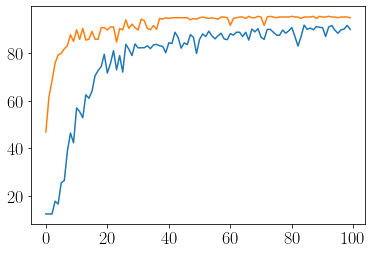

In [72]:
plot_learning_curve(dataset="lilac")

In [ ]:
df.head()
df=df.rename(columns={"train_loss": "Train-loss", "test_loss": "Test-loss",
                  "train_acc": "Train-acc", "test_acc": "Test-acc"})

In [ ]:
plt.plot(df["epoch"], df["Test-acc"], label="$\lambda=1, \delta=1$")
plt.legend()

### Layer normalization

In [ ]:
dataset="plaid"
image_type="adaptive"
model_name="CNN"
initilize_type="default"
run_id=1
width=50
p=1
results_cm = {}
results_f1={}
results_mcc={}
results_zl={}
names = plaid_names
train='sub'
test='agg'

initilizations = "default"
layers_type  = ["with-LN", "without-LN"]
results = pd.DataFrame( index=layers_type, columns=["F1", "MCC", "ZL"])
#for width in [20, 30, 50]:
fig=figure(fig_width=4)
for i, layer_norm  in enumerate([True, False]):
    file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_cross_dataset_{train}_{test}_{initilize_type}_{str(p)}"
    if layer_norm==False:
        file_name = file_name+"_without_layer_norm"
    pred = np.load("../results/"+file_name+"_pred.npy")
    true = np.load("../results/"+file_name+"_true.npy")
    df = pd.read_csv("../logs/"+file_name+".csv")
    plt.plot(df["epoch"], df["test_acc"], label=f"{layers_type[i]}")
    mcc  = matthews_corrcoef(true, pred)
    zl   = zero_one_loss(true, pred)*100
    cm   = confusion_matrix(true, pred)
    f1   = get_Fmeasure(cm, names)
    results_cm[layers_type[i]]=cm
    results_f1[layers_type[i]]=f1
    results_mcc[layers_type[i]]=mcc
    results_zl[layers_type[i]]=zl

results["F1"] = pd.Series(results_f1)
results["MCC"] = pd.Series(results_mcc)
results["ZL"] = pd.Series(results_zl)
results=results.round(2)
#plt.ylim(0,0.5)

plt.xlabel("Iterations")
plt.ylabel("validation accuracy $\%$")
plt.legend()


#savefig(fig_path+f"initilization_{dataset}_delta=10", format=".pdf")

In [ ]:
results

In [ ]:
dataset="plaid"
image_type="adaptive"
model_name="CNN"
initilize_type="default"
run_id=1
width=50
p=1
results_cm = {}
results_f1={}
results_mcc={}
results_zl={}
names = plaid_names
train='agg'
test='sub'

initilizations = "default"
layers_type  = ["with-LN", "without-LN"]
results = pd.DataFrame( index=layers_type, columns=["F1", "MCC", "ZL"])
#for width in [20, 30, 50]:
fig=figure(fig_width=4)
for i, layer_norm  in enumerate([True, False]):
    file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_cross_dataset_{train}_{test}_{initilize_type}_{str(p)}"
    if layer_norm==False:
        file_name = file_name+"_without_layer_norm"
    pred = np.load("../results/"+file_name+"_pred.npy")
    true = np.load("../results/"+file_name+"_true.npy")
    df = pd.read_csv("../logs/"+file_name+".csv")
    plt.plot(df["epoch"], df["test_acc"], label=f"{layers_type[i]}")
    mcc  = matthews_corrcoef(true, pred)
    zl   = zero_one_loss(true, pred)*100
    cm   = confusion_matrix(true, pred)
    f1   = get_Fmeasure(cm, names)
    results_cm[layers_type[i]]=cm
    results_f1[layers_type[i]]=f1
    results_mcc[layers_type[i]]=mcc
    results_zl[layers_type[i]]=zl

results["F1"] = pd.Series(results_f1)
results["MCC"] = pd.Series(results_mcc)
results["ZL"] = pd.Series(results_zl)
results=results.round(2)
#plt.ylim(0,0.5)

plt.xlabel("Iterations")
plt.ylabel("validation accuracy $\%$")
plt.legend()


#savefig(fig_path+f"initilization_{dataset}_delta=10", format=".pdf")

In [ ]:
results

In [ ]:
dataset="plaid"
image_type="adaptive"
model_name="CNN"
initilize_type="default"
run_id=1
width=50
p=1
results_cm = {}
results_f1={}
results_mcc={}
results_zl={}
names = plaid_names
train='agg'
test='sub'
layer_norm=False
initilizations = "default"
layers_type  = [1,2,3]
results = pd.DataFrame( index=layers_type, columns=["F1", "MCC", "ZL"])
#for width in [20, 30, 50]:
fig=figure(fig_width=4)
for i, p  in enumerate(layers_type):
    file_name=f"{dataset}_{image_type}_{str(width)}_{model_name}_{str(run_id)}_cross_dataset_{train}_{test}_{initilize_type}_{str(p)}"
    if layer_norm==False:
        file_name = file_name+"_without_layer_norm"
    pred = np.load("../results/"+file_name+"_pred.npy")
    true = np.load("../results/"+file_name+"_true.npy")
    df = pd.read_csv("../logs/"+file_name+".csv")
    plt.plot(df["epoch"], df["test_acc"], label=f"p={str(layers_type[i])}")
    mcc  = matthews_corrcoef(true, pred)
    zl   = zero_one_loss(true, pred)*100
    cm   = confusion_matrix(true, pred)
    f1   = get_Fmeasure(cm, names)
    results_cm[layers_type[i]]=cm
    results_f1[layers_type[i]]=f1
    results_mcc[layers_type[i]]=mcc
    results_zl[layers_type[i]]=zl

results["F1"] = pd.Series(results_f1)
results["MCC"] = pd.Series(results_mcc)
results["ZL"] = pd.Series(results_zl)
results=results.round(2)
#plt.ylim(0,0.5)

plt.xlabel("Iterations")
plt.ylabel("validation accuracy $\%$")
plt.legend()


In [ ]:
results